## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras
import numpy as np
import pandas as pd

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

def categorical_to_number(y):
    y_num = np.zeros((y.shape[0], 1))
    
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            if y[i][j] == 1:
                y_num[i] = j
                
    return y_num

def max_probability(y):
    max_y = np.zeros((y.shape[0], 1))
    
    for i in range(y.shape[0]):
        y_series = pd.Series(y[i, :], index=range(10))
        max_y[i] = y_series.idxmax(y_series)
        
        
    return max_y

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import Callback
from keras import backend as K
from sklearn.metrics import multilabel_confusion_matrix

record_items = ["class_0 - val_tp", "class_0 - val_tn", 
                "class_1 - val_tp", "class_1 - val_tn", 
                "class_2 - val_tp", "class_2 - val_tn", 
                "class_3 - val_tp", "class_3 - val_tn", 
                "class_4 - val_tp", "class_4 - val_tn", 
                "class_5 - val_tp", "class_5 - val_tn", 
                "class_6 - val_tp", "class_6 - val_tn", 
                "class_7 - val_tp", "class_7 - val_tn", 
                "class_8 - val_tp", "class_8 - val_tn", 
                "class_9 - val_tp", "class_9 - val_tn"]
# Record_fp_tp
class Record_tp_tn(Callback):
    
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        #y_pred_round = (y_pred[:, 1] >= thres) * 1
        
        y_pred_num = max_probability(y_pred)
#        print(y_true.shape)
#        print()
#        print(y_pred.shape)
#        print()
#        print(y_pred_num.shape)
#        print()
#        print(y_pred_num)
        
        CM = multilabel_confusion_matrix(y_true, y_pred_num, labels=[0,1,2,3,4,5,6,7,8,9])
#        print(CM)
        
        for i, items in enumerate(record_items):
            if i % 2 == 0:
                logs[items] = CM[i//2, 0, 0]
            else:
                logs[items] = CM[i//2, 1, 1]
        
#            print(str(items), logs[items])
        
rec_tptn = Record_tp_tn()

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
tp_tn_results = {}

for i, items in enumerate(record_items):
    if i % 2 == 0:
        exp_name_tag = "Class_%s_tp" % str(i//2)
    else:
        exp_name_tag = "Class_%s_tn" % str(i//2)
        
    tp_tn_results[exp_name_tag] = model.history.history[items]

W0730 16:16:14.186422 20724 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 16:16:14.197392 20724 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 16:16:14.198389 20724 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 16:16:14.272161 20724 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0730 16:16:14.387879 20724 deprecation_wr

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

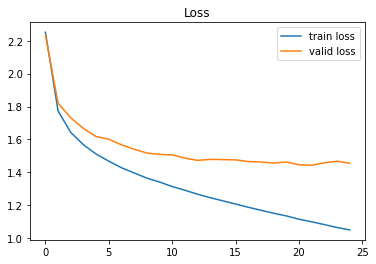

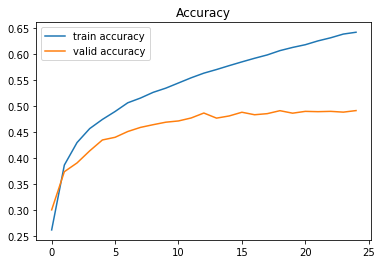

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

#plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
#plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
#plt.legend()
#plt.title("True positives and True Negatives")
#plt.show()


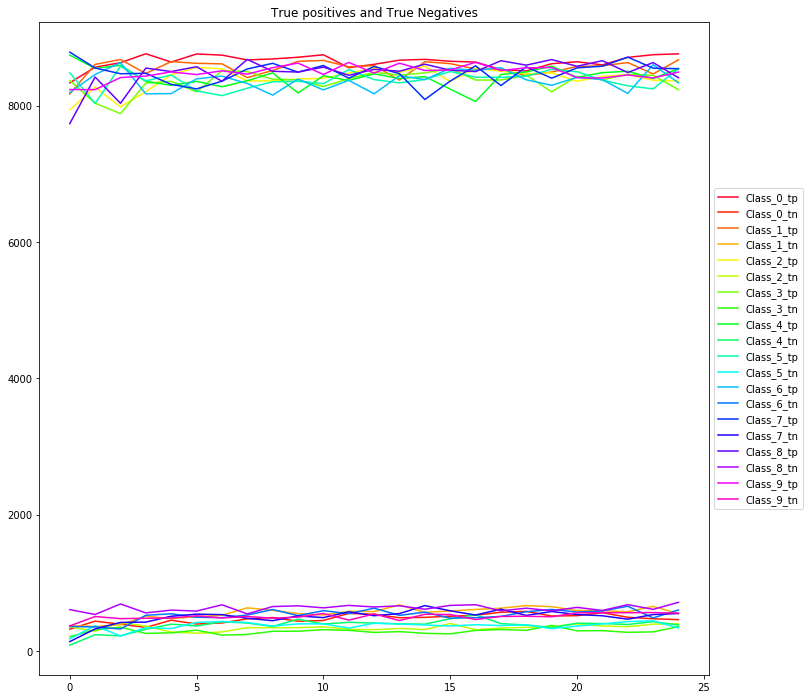

In [10]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(tp_tn_results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(12,12))
for i, cond in enumerate(tp_tn_results.keys()):
    plt.plot(range(len(tp_tn_results[cond])),tp_tn_results[cond], '-', label=cond, color=color_bar[i])
plt.title("True positives and True Negatives")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [14]:
for i, items in enumerate(record_items):
    if i % 2 == 0:
        exp_name_tag = "Class_%s_tp" % str(i//2)
    else:
        exp_name_tag = "Class_%s_tn" % str(i//2)
        
    print(str(exp_name_tag) + ":", tp_tn_results[exp_name_tag])
    print()

Class_0_tp: [8336, 8566, 8632, 8763, 8641, 8760, 8743, 8673, 8687, 8712, 8748, 8559, 8608, 8669, 8681, 8653, 8641, 8531, 8511, 8617, 8646, 8600, 8710, 8749, 8762]

Class_0_tn: [322, 439, 394, 347, 453, 397, 413, 473, 492, 438, 449, 553, 539, 489, 495, 511, 525, 570, 582, 515, 519, 563, 496, 474, 461]

Class_1_tp: [8174, 8607, 8679, 8474, 8648, 8623, 8615, 8413, 8518, 8651, 8666, 8572, 8590, 8377, 8646, 8618, 8539, 8529, 8444, 8495, 8576, 8586, 8634, 8467, 8674]

Class_1_tn: [373, 361, 387, 511, 477, 504, 526, 635, 597, 550, 529, 583, 580, 678, 568, 589, 611, 629, 667, 652, 595, 593, 576, 656, 547]

Class_2_tp: [7939, 8274, 7984, 8207, 8456, 8563, 8542, 8364, 8366, 8392, 8404, 8478, 8557, 8490, 8581, 8356, 8550, 8506, 8469, 8485, 8360, 8430, 8458, 8375, 8362]

Class_2_tn: [357, 291, 419, 366, 280, 261, 281, 343, 342, 344, 356, 320, 313, 332, 316, 405, 313, 338, 349, 359, 399, 368, 357, 396, 400]

Class_3_tp: [8371, 8037, 7885, 8333, 8359, 8203, 8513, 8502, 8390, 8381, 8281, 8398, 8491, 